# Model

We will create a blank object, called `model`, to hold the various pieces of information we have about our model.

In [1]:
class Model:
    pass

model = Model()

## Source Demographics Data

We have some census data for Nigeria (2015) which we will use to set the initial populations for our nodes. Since we are modeling northern Nigeria, as a first cut we will only choose administrative districts which start with "NORTH_". That gives us 419 nodes with a total population of ~96M.

In [2]:
# setup initial populations
from pathlib import Path

import numpy as np
from nigeria import lgas

print(Path.cwd())
admin2 = {k:v for k,v in lgas.items() if len(k.split(":")) == 5}
print(f"{len(admin2)=}")
# We need the indices of the Northern Nigeria nodes to subset the gravity matrix later
nn_node_indices = [i for i, k in enumerate(admin2.keys()) if k.split(":")[2].startswith("NORTH_")]
print(nn_node_indices)
print(f"{len(nn_node_indices)=}")
nn_nodes = {k:v for i, (k, v) in enumerate(admin2.items()) if i in nn_node_indices}

initial_populations = np.array([v[0][0] for v in nn_nodes.values()])
print(f"{len(initial_populations)=}")
print(initial_populations[0:32])
print(f"{initial_populations.sum()=:,}")

/workspaces/laser/nnmm
len(admin2)=774
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 

## Parameters

We need some parameters now. We will use `PropertySet` rather than a raw dictionary for the "syntactic sugar" of referencing `params.ticks` rather than `params["ticks"]` each time.

Also, we will set the parameters separately as `meta_params` and `measles_params` but combine them into one parameter set for future use. We _could_ create `model.params = PropertySet({"meta":meta_params, "measles":measles_params})` and then reference them "by path" in the subsequent code, e.g., `params.meta.ticks` and `params.measles.inf_mean`.

In [3]:
from idmlaser.utils import PropertySet

meta_params = PropertySet({
    "ticks": 3650,
    "cbr": 20,
    "output": Path.cwd() / "outputs",
})

measles_params = PropertySet({
    "exp_mean": np.float32(7.0),
    "exp_std": np.float32(1.0),
    "inf_mean": np.float32(7.0),
    "inf_std": np.float32(1.0),
    "r_naught": np.float32(14.0),
    "seasonality_factor": np.float32(0.125),
    "seasonality_phase": np.float32(182),
    "ri_coverage": np.float32(0.75)
})

model.params = PropertySet(meta_params, measles_params) # type: ignore


## Capacity Calculation

We have our initial populations, but we need to allocate enough space to handle growth during the simulation.

In [4]:
from idmlaser.numpynumba import Population

capacity = initial_populations.sum()
print(f"initial {capacity=:,}")
print(f"{model.params.cbr=}, {model.params.ticks=}")    # type: ignore
growth = ((1.0 + model.params.cbr/1000)**(model.params.ticks // 365))   # type: ignore
print(f"{growth=}")
capacity *= growth
capacity *= 1.01  # 1% buffer
capacity = np.uint32(np.round(capacity))
print(f"required {capacity=:,}")
print(f"Allocating capacity for {capacity:,} individuals")
population = Population(capacity)
model.population = population   # type: ignore
ifirst, ilast = population.add(initial_populations.sum())
print(f"{ifirst=:,}, {ilast=:,}")

initial capacity=96,171,118
model.params.cbr=20, model.params.ticks=3650
growth=1.2189944199947573
required capacity=118,404,377
Allocating capacity for 118,404,377 individuals
ifirst=0, ilast=96,171,118


## Node IDs

Add a property for node id. 419 nodes requires 9 bits so we will allocate a 16 bit value. Negative IDs don't make sense, so, `uint16`.

In [5]:
population.add_scalar_property("nodeid", np.uint16)
index = 0
for nodeid, count in enumerate(initial_populations):
    population.nodeid[index:index+count] = nodeid
    index += count


## Node Populations

We will need the most recent population numbers in order to determine the births, based on CBR, for the upcoming year. We will also, later, use the current population to determine the effective force of infection, i.e., total contagion / node population.

Default data type is uint32.

In [6]:
node_count = len(nn_nodes)
nodes = Population(capacity=node_count) # TODO: rename `Population` to some appropriate to agents _and_ nodes
model.nodes = nodes # type: ignore
ifirst, ilast = nodes.add(node_count)
print(f"{ifirst=:,}, {ilast=:,}")
nodes.add_vector_property("population", model.params.ticks + 1) # type: ignore
nodes.population[:,0] = initial_populations

ifirst=0, ilast=419


## Population per Tick

We will propagate the current populations forward on each tick. Vital dynamics of births and non-disease deaths will update the current values. The argument signature for per tick step phases is (`model`, `tick`). This lets functions access model specific properties and use the current tick, if necessary, e.g. record information or decide to act.

In [7]:
def propagate_population(model, tick):
    model.nodes.population[:,tick+1] = model.nodes.population[:,tick]

    return


## Vital Dynamics: Births

Let's implement births over time. We will use the CBR in `model.params` and draw for the number of births this year based on the most recent population. Then, we will distribute those births as evenly as possible for integral values over the days of the year.

Note that we add in the date of birth and date of non-disease death after we add those properties below.

Note that we add in initializing the susceptibility after we add that property below.

In [8]:
from idmlaser.kmcurve import pdsod

model.nodes.add_vector_property("births", (model.params.ticks + 364) // 365)    # births per year

# Adding ri_timer here since it's referred to in do_births.
model.population.add_scalar_property("ri_timer", np.uint16)

def do_births(model, tick):

    doy = tick % 365 + 1    # day of year 1...365
    year = tick // 365

    if doy == 1:
        model.nodes.births[:, year] = np.random.poisson(model.nodes.population[:, tick] * model.params.cbr / 1000)

    annual_births = model.nodes.births[:, year]
    todays_births = (annual_births * doy // 365) - (annual_births * (doy - 1) // 365)
    count_births = todays_births.sum()
    istart, iend = model.population.add(count_births)   # add count_births agents to the population, get the indices of the new agents

    # enable this after loading the aliased distribution and dod and dob properties (see cells below)
    model.population.dod[istart:iend] = pdsod(model.population.dob[istart:iend], max_year=100)   # make use of the fact that dob[istart:iend] is currently 0
    model.population.dob[istart:iend] = tick    # now update dob to reflect being born today

    # enable this after adding susceptibility property to the population (see cells below)
    model.population.susceptibility[istart:iend] = 1

    # Randomly set ri_timer for coverage fraction of agents to a value between 8.5*30.5 and 9.5*30.5 days
    # change these numbers or parameterize as needed
    ri_timer_values = np.random.uniform(8.5 * 30.5, 9.5 * 30.5, count_births).astype(np.uint16)
    
    # Create a mask to select coverage fraction of agents
    # TBD: do coverage by node, not same for every node
    mask = np.random.rand(count_births) < model.params.ri_coverage
    
    # Set ri_timer values for the selected agents
    model.population.ri_timer[istart:iend][mask] = ri_timer_values[mask]

    index = istart
    nodeids = model.population.nodeid   # grab this once for efficiency
    dods = model.population.dod # grab this once for efficiency
    max_tick = model.params.ticks
    for nodeid, births in enumerate(todays_births):
        nodeids[index:index+births] = nodeid
        for agent in range(index, index+births):
            # If the agent will die before the end of the simulation, add it to the queue
            if dods[agent] < max_tick:
                model.nddq.push(agent)
        index += births
    model.nodes.population[:,tick+1] += todays_births

    return


## Non-Disease Mortality Part I

We start by loading a population pyramid in order to initialize the ages of the initial population realistically.

The population pyramid is typically in 5 year age buckets. Once we draw for the age bucket, we draw uniformly for a date of birth within the range of the bucket.

**Note:** the values in `model.population.dob` are _positive_ at this point. Later we will negate them to convert them to dates of birth prior to now (t = 0).

In [9]:
from tqdm import tqdm

import idmlaser.pyramid as pyramid

pyramid_file = Path.cwd().parent / "tests" / "USA-pyramid-2023.csv"
print(f"Loading pyramid from '{pyramid_file}'...")
age_distribution = pyramid.load_pyramid_csv(pyramid_file)
print("Creating aliased distribution...")
aliased_distribution = pyramid.AliasedDistribution(age_distribution[:,4])
count_active = initial_populations.sum()
print(f"Sampling {count_active:,} ages... {population.count=:,}")
buckets = aliased_distribution.sample(population.count)
minimum_age = age_distribution[:, 0] * 365      # closed, include this value
limit_age = (age_distribution[:, 1] + 1) * 365  # open, exclude this value
population.add_scalar_property("dob", np.int32)
mask = np.zeros(capacity, dtype=bool)

print("Converting age buckets to ages...")
for i in tqdm(range(len(age_distribution))):
    mask[:count_active] = (buckets == i)    # indices of agents in this age group bucket
    # draw uniformly between the start and end of the age group bucket
    population.dob[mask] = np.random.randint(low=minimum_age[i], high=limit_age[i], size=mask.sum())


Loading pyramid from '/workspaces/laser/tests/USA-pyramid-2023.csv'...
Reading data from '/workspaces/laser/tests/USA-pyramid-2023.csv' ...
Creating aliased distribution...
Sampling 96,171,118 ages... population.count=96,171,118
Converting age buckets to ages...


100%|██████████| 21/21 [00:04<00:00,  4.50it/s]


## Non-Disease Mortality Part II

We import `pdsod` ("predicted_days_of_death") which currently uses a USA 2003 survival table. `pdsod` will draw for a year of death (in or after the current age year) and then will draw a day in the selected year.

**Note:** the incoming values in `model.population.dob` are positive (_ages_). After we use them to draw for date of death, we negate them to convert them to dates of birth (in days) prior to now (t=0).

In [10]:
from datetime import datetime

from idmlaser.kmcurve import pdsod

population.add_scalar_property("dod", np.int32)
dobs = population.dob
dods = population.dod
tstart = datetime.now(tz=None)  # noqa: DTZ005
dods[0:population.count] = pdsod(dobs[0:population.count], max_year=100)
tfinish = datetime.now(tz=None)  # noqa: DTZ005
print(f"Elapsed time for drawing dates of death: {tfinish - tstart}")

dods -= dobs.astype(dods.dtype) # renormalize to be relative to _now_ (t = 0)
dobs *= -1  # convert ages to date of birth prior to _now_ (t = 0) ∴ negative
print(f"First 32 DoBs (should all be negative - these agents were born before today):\n{dobs[:32]}")
print(f"First 32 DoDs (should all be positive - these agents will all pass in the future):\n{dods[:32]}")

Elapsed time for drawing dates of death: 0:00:00.749224
First 32 DoBs (should all be negative - these agents were born before today):
[-19692  -2493  -5098 -11704 -15104 -18909  -7499 -18830 -24939  -4183
 -20828 -23482 -24188 -23010 -19878 -20192 -24271 -19404  -2877 -15900
 -13810 -16049  -3710  -8654 -18241  -2583 -12673 -14743  -7896  -3164
 -17925  -4645]
First 32 DoDs (should all be positive - these agents will all pass in the future):
[15542 25247 21858 15670 14835  6560 21084  7535  3319 29812   615 11832
  6665  4128  6987  7710 11874 12510 23432 13480 13627 19078 18771 22791
 11000 29571 15467  2412 16901 22285 16308 29546]


## Non-Disease Mortality Part III

If we had no births, we could use a regular FIFO queue with the dates of death sorted to process non-disease deaths in time order. However, we may have agents born during the simulation who are predicted to die from non-disease causes before the end of the simulation and need to be insert, in sorted order, into the queue. So, we will use a priority queue - a data structure which allows for efficient insertion and removal while maintaining sorted order - to keep track of agents by date of non-disease death.

In [11]:
from idmlaser.utils import PriorityQueuePy

tstart = datetime.now(tz=None)  # noqa: DTZ005
dods = population.dod
mortality = PriorityQueuePy(capacity, dods)
for i in tqdm(indices := np.nonzero(dods[0:population.count] < model.params.ticks)[0]):
    mortality.push(i)
tfinish = datetime.now(tz=None)  # noqa: DTZ005

print(f"Elapsed time for pushing dates of death: {tfinish - tstart}")
print(f"Non-disease mortality: tracked {len(indices):,}, untracked {population.count - len(indices):,}")

model.nddq = mortality

100%|██████████| 11177727/11177727 [00:15<00:00, 738167.67it/s]

Elapsed time for pushing dates of death: 0:00:15.278485
Non-disease mortality: tracked 11,177,727, untracked 84,993,391


## Non-Disease Mortality Part IV

During the simulation, we will process all agents with a predicated date of death today marking them as deceased and removing them from the active population count.

**_TODO:_** Set a state to indicate "deceased" _or_ ignore the priority queue altogether and compare `dod` against `tick` and ignore agents where `dod < tick`.

In [12]:
model.nodes.add_vector_property("deaths", (model.params.ticks + 364) // 365)    # deaths per year

def do_non_disease_deaths(model, tick):

    pq = model.nddq
    year = tick // 365
    while len(pq) > 0 and pq.peekv() <= tick:
        i = pq.popi()
        nodeid = model.population.nodeid[i]
        model.nodes.population[nodeid,tick+1] -= 1
        model.nodes.deaths[nodeid,year] += 1

    return

## Incubation and Infection

We will add incubation timer (`etimer` for "exposure timer") and an infection (or infectious) timer (`itimer`) properties to the model population. A `uint8` counting down from as much as 255 days will be more than enough.

We wrap a Numba compiled function using all available cores in the infection update function, extracting the `count` and `itimer` values the JITted function needs.

Similarly, we wrap a Numba compiled function using all available cores in the exposure update function, extracting the values the JITted function needs from the `model` object.

In [13]:
import numba as nb

model.population.add_scalar_property("etimer", np.uint8)
model.population.add_scalar_property("itimer", np.uint8)

@nb.njit((nb.uint32, nb.uint8[:]), parallel=True)
def _infection_update(count, itimers):
    for i in nb.prange(count):
        if itimers[i] > 0:
            itimers[i] -= 1

    return

def do_infection_update(model, tick):

    _infection_update(nb.uint32(model.population.count), model.population.itimer)

    return

@nb.njit((nb.uint32, nb.uint8[:], nb.uint8[:], nb.float32, nb.float32), parallel=True)
def _exposure_update(count, etimers, itimers, inf_mean, inf_std):
    for i in nb.prange(count):
        if etimers[i] > 0:
            etimers[i] -= 1
            if etimers[i] == 0:
                itimers[i] = np.random.normal(inf_mean, inf_std)

    return

def do_exposure_update(model, tick):

    _exposure_update(nb.uint32(model.population.count), model.population.etimer, model.population.itimer, model.params.inf_mean, model.params.inf_std)

    return

## Susceptibility

We add a `susceptibility` property to the population in order to identify susceptible agents.

Maternal immunity, once implemented, will mean setting `susceptibility = 0` at birth and then setting `susceptibility = 1` at some point in the future when maternal antibodies have been determined to have waned.

RI, once implemented, will set `susceptibility = 0` if the infant is determined to get an efficacious innoculation. The infant might _not_ get an innoculation depending on RI coverage in their home node. Also, an RI innoculation might not be efficacious due to interference by maternal antibodies or just by vaccine failure.

Transmission, once implemented, will set `susceptibility = 0` so the agent is not considered for future transmission. I.e., agents in the exposed, infectious, recovered, or deceased state should have `susceptibility` set to 0.

**Note:** We initialize `susceptibility` to 0 since the majority of the initial population will have already been exposed to measles or have been vaccinated. First cut here is to set all agents under age 5 as susceptible.

**_TODO:_** Update this function to consider maternal immunity. Children under 1(?) year of age should draw for a date of maternal immunity waning. If they are _under_ that age, their susceptibility should be set to `0` and they should be put in a priority queue based on waning date to have their susceptibility set to `1`.

**_TODO:_** Update this function to probabilistically set susceptibility to `0` for children over 1 year of age based on local RI coverage and other factors (estimated prevalence and probability of _not_ having had measles?).

In [14]:
model.population.add_scalar_property("susceptibility", np.uint8)

# initialize susceptibility based on age
@nb.njit((nb.uint32, nb.int32[:], nb.uint8[:]), parallel=True)
def initialize_susceptibility(count, dob, susceptibility):

    for i in nb.prange(count):
        if dob[i] >= -365*5:
            susceptibility[i] = 1

    return

initialize_susceptibility(model.population.count, model.population.dob, model.population.susceptibility)

## Routine Immunization - RI

- Children under 1(?) year of age should draw for a date of RI (consider whether to draw vs. RI coverage in the node before choosing an RI date or later when their RI date comes up). Children with an RI date in the future should be put in a priority queue to be processed on their date of RI.
  - There can be a single `riq` for the model, there is no need to differentiate by node (any node heterogeneity can be considered when their RI date comes up).

- Create a tick/step phase function to process all agents with RI due on the given tick (see do_non_disease_deaths). This function draws to determine if the innoculation happens (based on RI coverage if the draw is not done at birth), determines if the innoculation is efficacious (potential maternal immunity interference or just vaccine failure). If the vaccination does not take, the agent should be considered for a follow-up RI at 15 months which would be in an additional RI priority queue.

- Update do_births to draw for RI (based on coverage) and RI date (based on RI date distribution) and put them into the `model.riq` (or set an RI timer...).

In [15]:
# Define the function to decrement ri_timer and update susceptibility
@nb.njit((nb.uint32, nb.uint16[:], nb.uint8[:]), parallel=True)
def _update_susceptibility_based_on_ri_timer(count, ri_timer, susceptibility):
    for i in nb.prange(count):
        if ri_timer[i] > 0:
            ri_timer[i] -= 1
            # TBD: It's perfectly possible that the individual got infected (or recovered) while this timer
            # was counting down and we might want to abort the timer.
            if ri_timer[i] == 0:
                susceptibility[i] = 0

# Example usage
#update_susceptibility_based_on_ri_timer(model.population.count, model.population.ri_timer, model.population.susceptibility)

def do_ri(model,tick):
    _update_susceptibility_based_on_ri_timer(model.population.count, model.population.ri_timer, model.population.susceptibility)
    return

## Initial Infections

We choose up to 10 infections per node initially. Another option would be to choose the initial number of infections based on estimated prevalence.

**Note:** this function has a known bug based on using Numba to optimize the function. [Numba only exposes an atomic decrement in CUDA implementations](https://numba.readthedocs.io/en/stable/cuda/intrinsics.html) so on the CPU it is possible that more than one thread decides there are still agents to initialize as infected and the total count of initial infections is more than specified.

**_TODO:_** After checking to see if there are still infections to be initialized in this node, consider checking the susceptibility of the agent as well, i.e., only infect susceptible agents.

**_TODO_:** Fix this with a compiled C/C++ function and [OpenMP 'atomic update'](https://www.openmp.org/spec-html/5.0/openmpsu95.html).

In [16]:
initial_infections = np.random.randint(0, 11, model.nodes.count, dtype=np.uint8)

@nb.njit((nb.uint32, nb.uint8[:], nb.uint16[:], nb.uint8[:], nb.float32, nb.float32), parallel=True)
def initialize_infections(count, infections, nodeid, itimer, inf_mean, inf_std):

    for i in nb.prange(count):
        if infections[nodeid[i]] > 0:
            infections[nodeid[i]] -= 1
            itimer[i] = np.random.normal(inf_mean, inf_std)

    return

# Print this _before_ initializing infections because `initial_infections` is modified in-place.
print(f"{initial_infections.sum()=:,}")

initialize_infections(np.uint32(model.population.count), initial_infections, model.population.nodeid, model.population.itimer, model.params.inf_mean, model.params.inf_std)

print(f"{(model.population.itimer > 0).sum()=:,}")

initial_infections.sum()=2,061
(model.population.itimer > 0).sum()=2,061


## Transmission Part I - Setup

## Transmission Part II - Tick/Step Processing Phase

## Tick/Step Processing Phases

The phases (sub-steps) of the processing on each tick go here as they are implemented.

In [17]:
# consider `step_functions` rather than `phases` for the following
model.phases = [
    propagate_population,
    do_births, # type: ignore
    do_non_disease_deaths, # type: ignore
    do_infection_update, # type: ignore
    do_exposure_update, # type: ignore
]


## Running the Simulation

We iterate over the specified number of ticks, keeping track, in `metrics`, of the time spent in each phase at each tick.

In [18]:
from datetime import datetime

from tqdm import tqdm

model.metrics = []
for tick in tqdm(range(model.params.ticks)):
    metrics = [tick]
    for phase in model.phases:
        tstart = datetime.now(tz=None)  # noqa: DTZ005
        phase(model, tick)
        tfinish = datetime.now(tz=None)  # noqa: DTZ005
        delta = tfinish - tstart
        metrics.append(delta.seconds * 1_000_000 + delta.microseconds)  # delta is a timedelta object, let's convert it to microseconds
    model.metrics.append(metrics)


  0%|          | 0/3650 [00:00<?, ?it/s]

100%|██████████| 3650/3650 [01:58<00:00, 30.76it/s]


## Timing Metrics Part I

Let's convert the timing information to a DataFrame and peek at the first few entries.

In [19]:
import pandas as pd

metrics = pd.DataFrame(model.metrics, columns=["tick"] + [phase.__name__ for phase in model.phases])
metrics.head()

,tick,propagate_population,do_births,do_non_disease_deaths,do_infection_update,do_exposure_update
0,0,17,2408,6,5254,8882
1,1,15,2119,77053,5437,8361
2,2,14,2173,56914,5593,8277
3,3,8,2136,52819,5425,8223
4,4,11,2168,48143,5439,8211


## Timing Metrics Part II

Let's take a look at where we spend our processing time.

propagate_population        30547
do_births                 9071679
do_non_disease_deaths    49788686
do_infection_update      22991108
do_exposure_update       35423689
dtype: int64
Total:                117,305,709


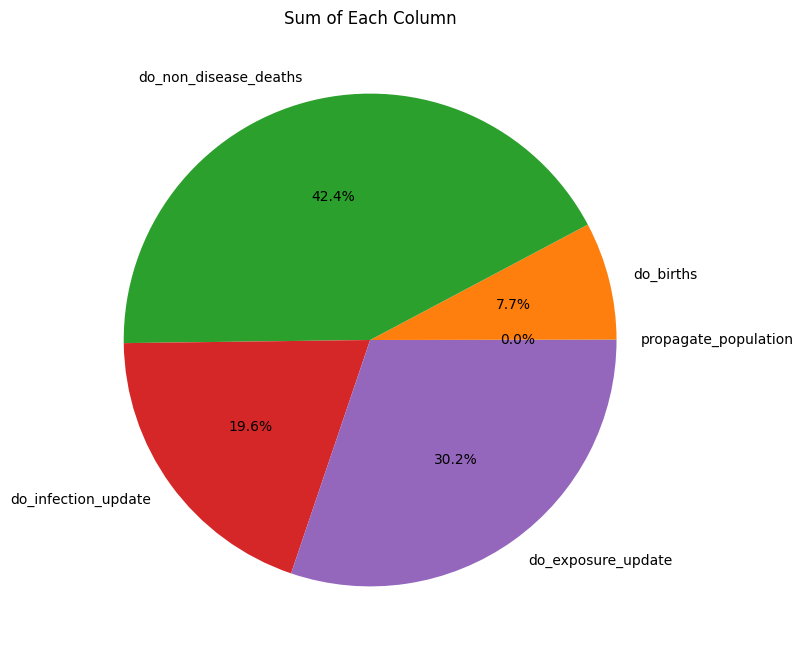

In [20]:
import matplotlib.pyplot as plt

plot_columns = metrics.columns[1:]
sum_columns = metrics[plot_columns].sum()
print(sum_columns)
print("=" * 33)
print(f"Total: {sum_columns.sum():26,}")
plt.figure(figsize=(8, 8))
plt.pie(sum_columns, labels=sum_columns.index, autopct="%1.1f%%")
plt.title("Sum of Each Column")
plt.show()

## Validation - Population Over Time

Let's make sure that our population is growing over time by plotting the population for a few nodes.

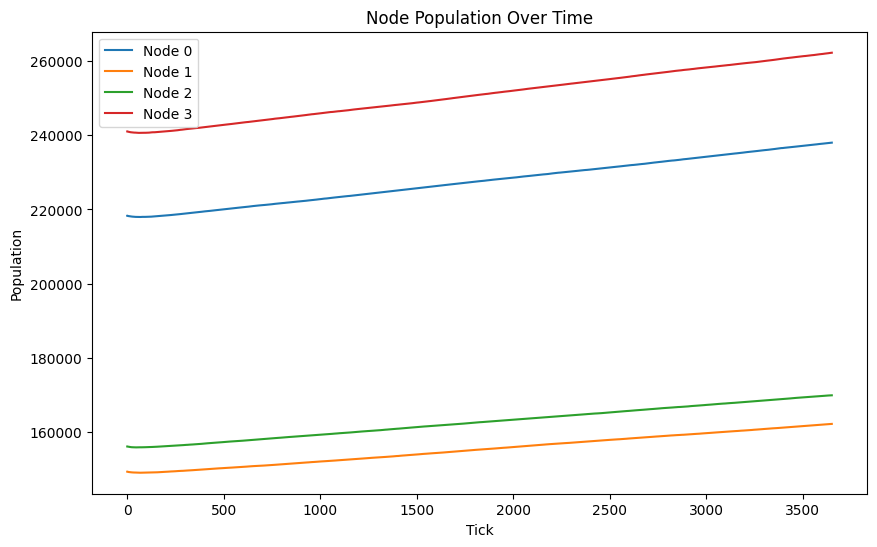

In [21]:
from matplotlib import pyplot as plt

nodes_to_plot = [0, 1, 2, 3]
node_population = model.nodes.population[nodes_to_plot, :]

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range(model.params.ticks + 1), node_population[i, :], label=f"Node {node}")

plt.xlabel("Tick")
plt.ylabel("Population")
plt.title("Node Population Over Time")
plt.legend()
plt.show()

## Validation - Births

Let's see if our births over time look right. Given a fixed CBR and a growing population, we should generally have more births later in the simulation.

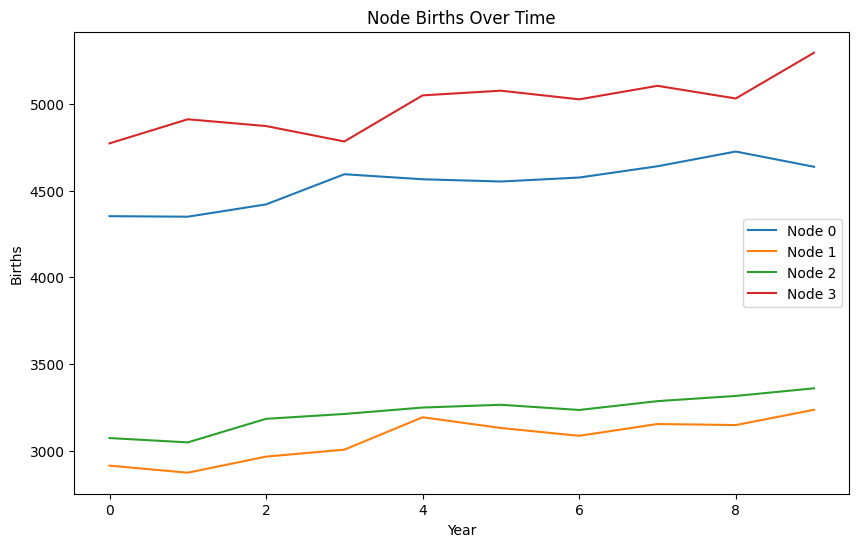

In [22]:
from matplotlib import pyplot as plt

node_births = model.nodes.births[nodes_to_plot, :]

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range((model.params.ticks + 364) // 365), node_births[i, :], label=f"Node {node}")

plt.xlabel("Year")
plt.ylabel("Births")
plt.title("Node Births Over Time")
plt.legend()
plt.show()

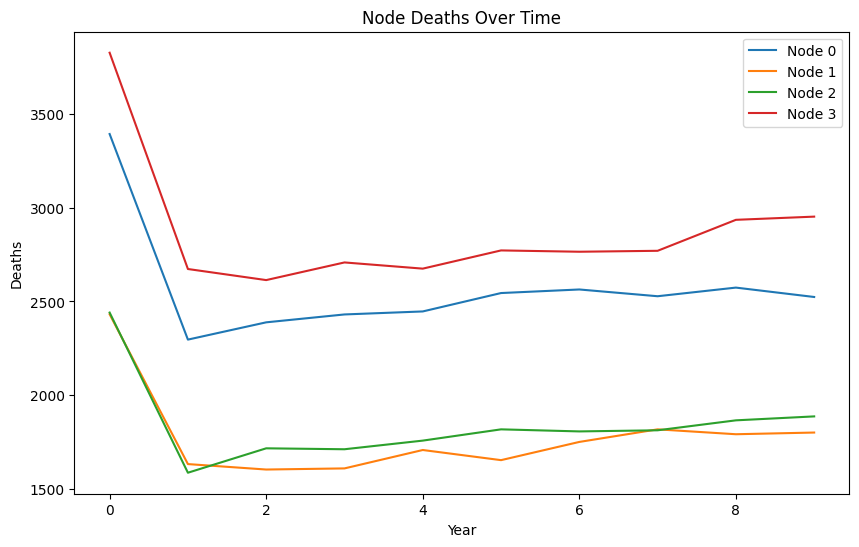

In [23]:
from matplotlib import pyplot as plt

node_births = model.nodes.deaths[nodes_to_plot, :]

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range((model.params.ticks + 364) // 365), node_births[i, :], label=f"Node {node}")

plt.xlabel("Year")
plt.ylabel("Deaths")
plt.title("Node Deaths Over Time")
plt.legend()
plt.show()